In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import tensorflow
import tensorflow as tf
print(tf.__version__)

2.10.0


In [2]:
# Get the list of available GPUs
gpu_devices = tf.config.experimental.list_physical_devices('GPU')

# Print the list of available GPUs
print("Available GPUs:", gpu_devices)

# Check if TensorFlow is using GPU
if gpu_devices:
    print("TensorFlow is using GPU.")
    # Specify which GPU to use (assuming you have at least one GPU)
    tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
else:
    print("TensorFlow is NOT using GPU.")

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is using GPU.


# Get Dataset

In [13]:
import wget

# download data
# wget.download(url="https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip", out="cat_vs_dog.zip")

'cat_vs_dog.zip'

In [16]:
import zipfile

# unzip
zip_ref = zipfile.ZipFile("cat_vs_dog.zip", "r")
zip_ref.extractall("./")
zip_ref.close()


In [19]:
import os

# base dir
base_dir = "./cats_and_dogs_filtered"

# train cat dir
train_cat_dir = os.path.join(base_dir, "./train")

# train dog dir
train_dog_dir = os.path.join(base_dir, "./train")

# val cat dir
val_cat_dir = os.path.join(base_dir, "./validation")

# val dog dir
val_dog_dir = os.path.join(base_dir, "./validation")

# import image generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# add our data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# should not augmented
val_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
    "./cats_and_dogs_filtered/train",
    batch_size= 20,
    class_mode="binary",
    target_size=(150, 150)
)

val_generator = val_datagen.flow_from_directory(
    "./cats_and_dogs_filtered/validation",
    batch_size=20,
    class_mode="binary",
    target_size=(150, 150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Get Pre Trained Model

In [3]:
# download using wget
import wget

# InceptionV3 URL
model_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# download
# wget.download(model_url, out="inception_v3_weights.h5")

In [4]:
# import necessary package
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# file location
local_weights_file = "inception_v3_weights.h5"

# initialize the base model
# set input shape and remove dense layer
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3),
    include_top = False,
    weights = None
)

# load downloaded file
pre_trained_model.load_weights(local_weights_file)

# freeze the weights of the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

In [5]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [9]:
# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer("mixed7")
print("last layer output shape: ", last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


# Add Our Dense Layer

In [10]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten layer
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation="sigmoid")(x)

# Append model
model = Model(pre_trained_model.input, x)

# summary
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [12]:
# compile
model.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [21]:
# training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_steps=50,
    verbose=1
)

Epoch 1/20
100/100 [==============================] - 58s 412ms/step - loss: 0.3366 - accuracy: 0.8625 - val_loss: 0.1064 - val_accuracy: 0.9600
Epoch 2/20
100/100 [==============================] - 20s 199ms/step - loss: 0.2084 - accuracy: 0.9235 - val_loss: 0.1330 - val_accuracy: 0.9560
Epoch 3/20
100/100 [==============================] - 17s 172ms/step - loss: 0.2239 - accuracy: 0.9190 - val_loss: 0.0940 - val_accuracy: 0.9620
Epoch 4/20
100/100 [==============================] - 17s 169ms/step - loss: 0.1832 - accuracy: 0.9385 - val_loss: 0.1033 - val_accuracy: 0.9650
Epoch 5/20
100/100 [==============================] - 17s 165ms/step - loss: 0.2043 - accuracy: 0.9295 - val_loss: 0.1049 - val_accuracy: 0.9640
Epoch 6/20
100/100 [==============================] - 17s 167ms/step - loss: 0.1686 - accuracy: 0.9445 - val_loss: 0.0913 - val_accuracy: 0.9700
Epoch 7/20
100/100 [==============================] - 17s 168ms/step - loss: 0.1595 - accuracy: 0.9440 - val_loss: 0.1152 - val_ac

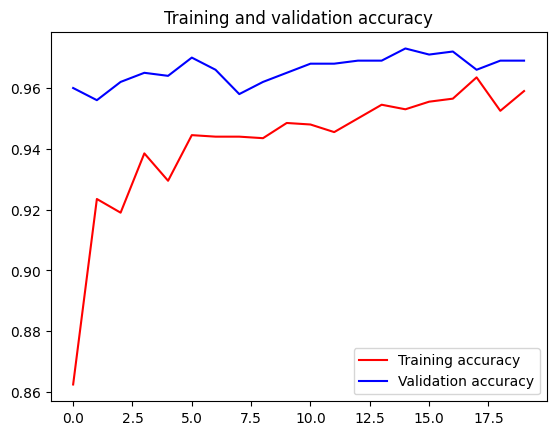

<Figure size 640x480 with 0 Axes>

In [22]:
# Evaluate model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()